# Project Goal

Characterize materials using ultrasound.
Goal is to analyze and characterize materials groups such as plastics, composites and metals.




## Oscillation Frequency Choice

In [75]:
def calc_bulk_modulus(youngs_modulus=None, poisson_ratio=None, shear_modulus=None):
	if (shear_modulus != None):
		return (youngs_modulus * shear_modulus / (9*shear_modulus - 3 * youngs_modulus))
	elif (poisson_ratio != None):
		return (youngs_modulus / (2*(1+poisson_ratio)))
	else:
		print("ERROR")

In [92]:
# Container for fetched data
materials_data = {}

##########################################################################################
######################## The Materials Project imports ###################################
##########################################################################################
import math
import sys
import os
sys.path.insert(0, os.path.abspath("") + '/ae_secrets')
from mp_api.client import MPRester
import numpy as np
from mq_secrets import API_KEY
# Replace with your actual API key
from pymatgen.ext.matproj import MPRester
from pprint import pprint

#! Materials
categories = {
    "Metals": {
        "Copper": "mp-30", 
        "Tin": "mp-117",
        "Iron": "mp-13"
	}
}


# Fetch data using the mp-api client’s summary.search endpoint
with MPRester(API_KEY) as mpr:
	# Get PCB materials
	mlist = list(categories["Metals"].values())
	mkeys = list(categories["Metals"].keys())
	docs = mpr.materials.summary.search(material_ids=mlist)
	for i, d in enumerate(docs):
		rho = d['density']
		K = d['bulk_modulus']['vrh'] # GPa
		G = d['shear_modulus']['vrh'] # GPa

		## convert GPa→Pa, g/cm³→kg/m³ for SI:
		rho_si = rho * 1e3  
		K_si = K * 1e9
		G_si = G * 1e9
		materials_data[mkeys[i]] = {}
		materials_data[mkeys[i]]['rho_si'] = rho_si
		materials_data[mkeys[i]]['K_si'] = K_si
		materials_data[mkeys[i]]['G_si'] = G_si

##########################################################################################
############################## Manual findings ###########################################
##########################################################################################

# FR-4 (glass‐reinforced epoxy laminate) – typical engineering averages, https://www.cctprecision.com/materials/g10/?, verify with: https://www.researchgate.net/figure/ariation-in-velocities-of-shear-wave-in-the-direction-of-h-30-with-x-axis-at-different_fig3_220564972
fr4_data = {
	'rho_si': 1.9e3,  # ~1.9 g/cm³ → 1900 kg/m³
    'G_si': 8.0e9,    # G ≈ 8 GPa (typical shear modulus of FR-4) 
    'K_si': 30.0e9       # ν ≈ 0.14 for FR-4
}
materials_data['FR4'] = fr4_data


# Aluminum
aluminum_data = {'rho_si': ((2.57+2.95)/2)*1.0e3, 'K_si': ((62+106) / 2)*1.0e9, 'G_si': ((25+34) / 2) * 1.0e9}
materials_data['aluminum'] = aluminum_data

pla_data = {'rho_si': 1.25e3, 'K_si': calc_bulk_modulus(youngs_modulus=3.5e9, shear_modulus=2.4e9), 'G_si': 2.4e9}
materials_data['pla'] = pla_data
# https://designerdata.nl/materials/plastics/thermo-plastics/acrylonitril-butadieen-styreen-general-purpose
abs_data = {'rho_si': 1.11e3, 'K_si': calc_bulk_modulus(youngs_modulus=2.2e9, shear_modulus=0.875e9), 'G_si': 2.4e9}
materials_data['abs'] = abs_data
# https://pmc.ncbi.nlm.nih.gov/articles/PMC11013115/#:~:text=At%2040%20%C2%B0C%2C%20the,transition%20temperature%20of%20the%20specimen.
resin_data = {'rho_si': 1.11e3, 'K_si': 4e9, 'G_si': 1.2e9}
resin_data['resin'] = resin_data

##########################################################################################
############################## Data Computation ##########################################
##########################################################################################


for key, mdict in materials_data.items():
		K_si = mdict['K_si']
		G_si = mdict['G_si']
		rho_si = mdict['rho_si']
		## longitudinal speed: sqrt((K + 4/3 G)/ρ)
		v_l = math.sqrt((K_si + 4/3*G_si)/rho_si)
		## shear speed: sqrt(G/ρ)
		v_s = math.sqrt(G_si/rho_si)
		mdict['v_l'] = v_l
		mdict['v_s'] = v_s
pprint(materials_data)

{'Copper': {'G_si': 49843000000.0,
            'K_si': 151394000000.0,
            'rho_si': 9218.99604714547,
            'v_l': 4861.14187957575,
            'v_s': 2325.199777420447},
 'FR4': {'G_si': 8000000000.0,
         'K_si': 30000000000.0,
         'rho_si': 1900.0,
         'v_l': 4626.392630541622,
         'v_s': 2051.956704170308},
 'Iron': {'G_si': 67563000000.0,
          'K_si': 207093000000.0,
          'rho_si': 7902.858241785766,
          'v_l': 6132.188568246844,
          'v_s': 2923.8989999951445},
 'Tin': {'G_si': 22399000000.0,
         'K_si': 35858000000.0,
         'rho_si': 5560.776472065438,
         'v_l': 3437.8907531449627,
         'v_s': 2006.9964111037352},
 'abs': {'G_si': 2400000000.0,
         'K_si': 1509803921.5686274,
         'rho_si': 1110.0,
         'v_l': 2059.8705289429654,
         'v_s': 1470.4292441876155},
 'aluminum': {'G_si': 29500000000.0,
              'K_si': 84000000000.0,
              'rho_si': 2760.0,
              'v_l': 66

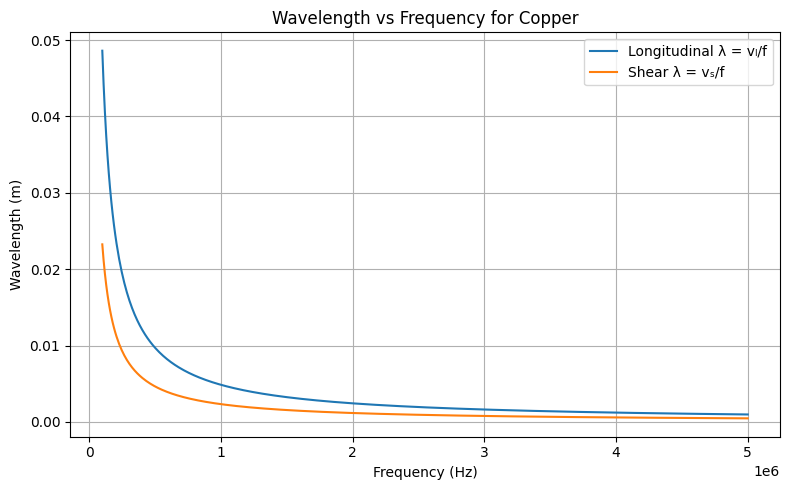

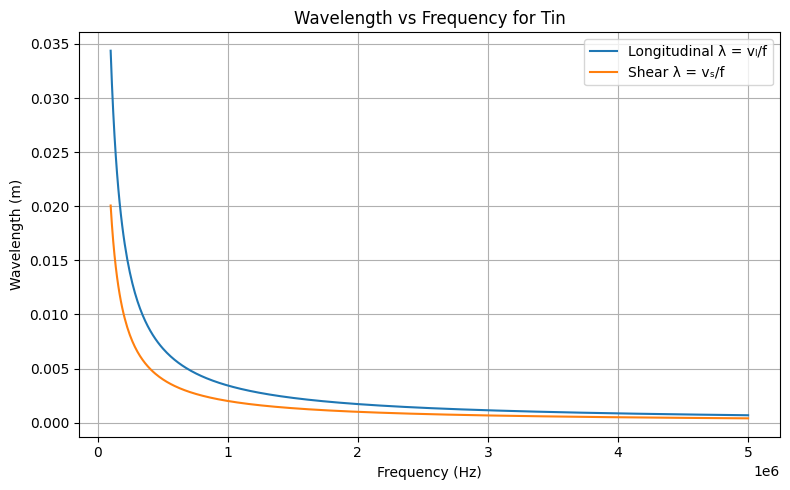

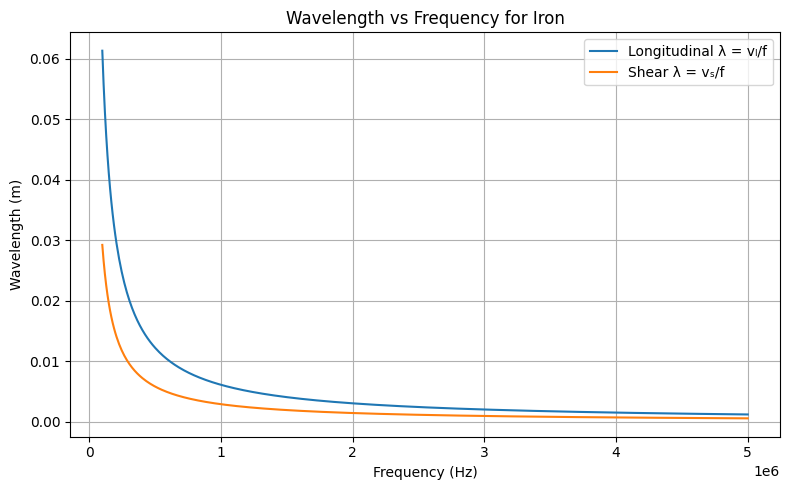

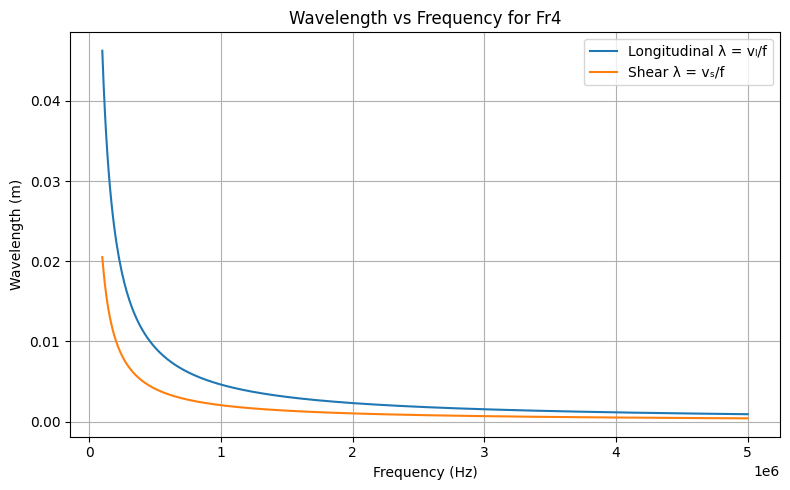

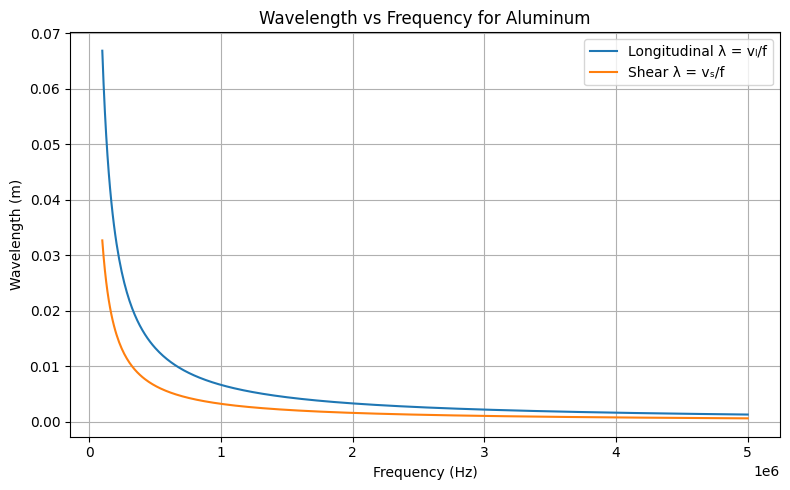

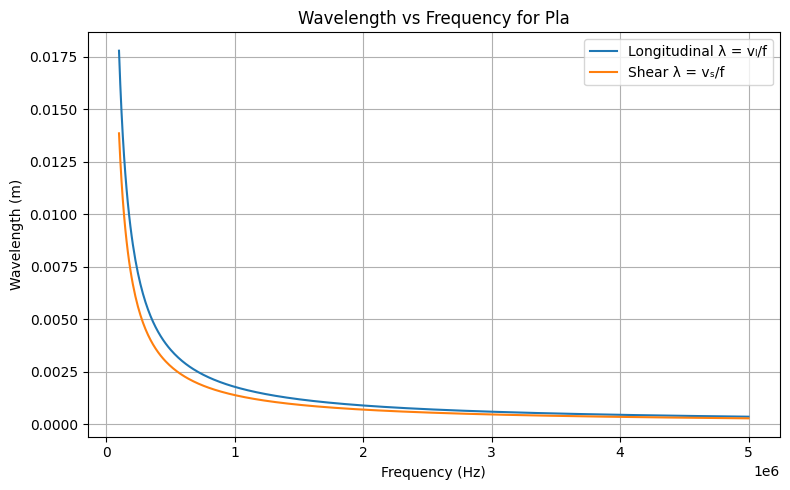

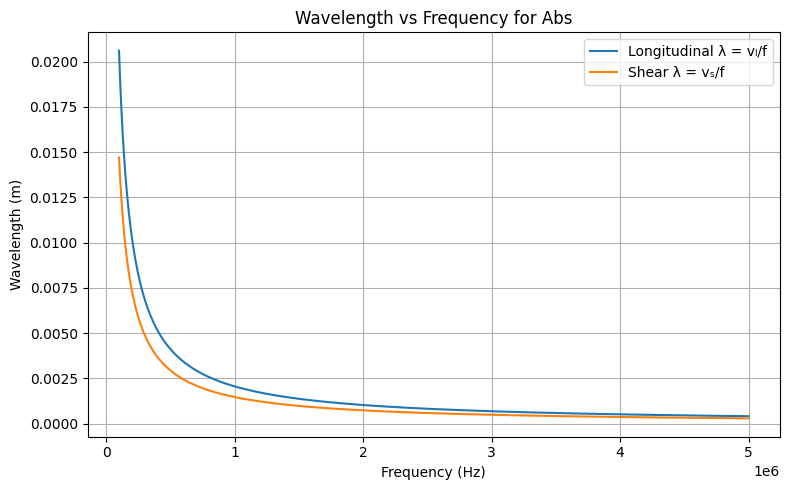

In [109]:
# Material Properties
import numpy as np
import matplotlib.pyplot as plt

# Frequencies from 100 kHz to 50 MHz
frequencies = np.linspace(1e5, 5e6, 500)  # Hz :contentReference[oaicite:2]{index=2}

# Wavelength = speed / frequency
def wavelength(speed, freq):
    return speed / freq

# Plot for each material
for material, speeds in materials_data.items():
    lam_l = wavelength(speeds['v_l'], frequencies)
    lam_s = wavelength(speeds['v_s'], frequencies)

    plt.figure(figsize=(8, 5))
    plt.plot(frequencies, lam_l, label='Longitudinal λ = vₗ/f')
    plt.plot(frequencies, lam_s, label='Shear λ = vₛ/f')
    plt.title(f'Wavelength vs Frequency for {material.capitalize()}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Wavelength (m)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

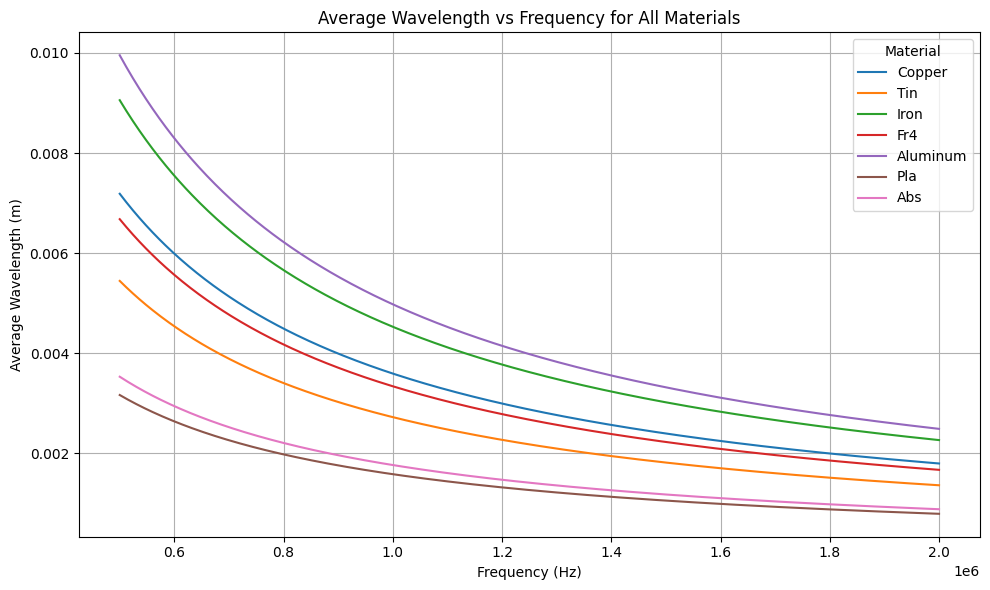

In [110]:
# Frequency range: 100 kHz to 50 MHz
frequencies = np.linspace(500e3, 2e6, 500)  # in Hz
wavelengths_avg_dict = {}
# Plot average wavelength for each material
plt.figure(figsize=(10, 6))
for idx, (material, speeds) in enumerate(materials_data.items()):
    avg_speed = (speeds['v_l'] + speeds['v_s']) / 2
    wavelengths_avg = avg_speed / frequencies
    wavelengths_avg_dict[material.capitalize()] = wavelengths_avg
    plt.plot(frequencies, wavelengths_avg, label=material.capitalize())
    
plt.title('Average Wavelength vs Frequency for All Materials')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Wavelength (m)')
plt.legend(title='Material')
plt.grid(True)
plt.tight_layout()
plt.show()

piezo-frequencies: (500,)


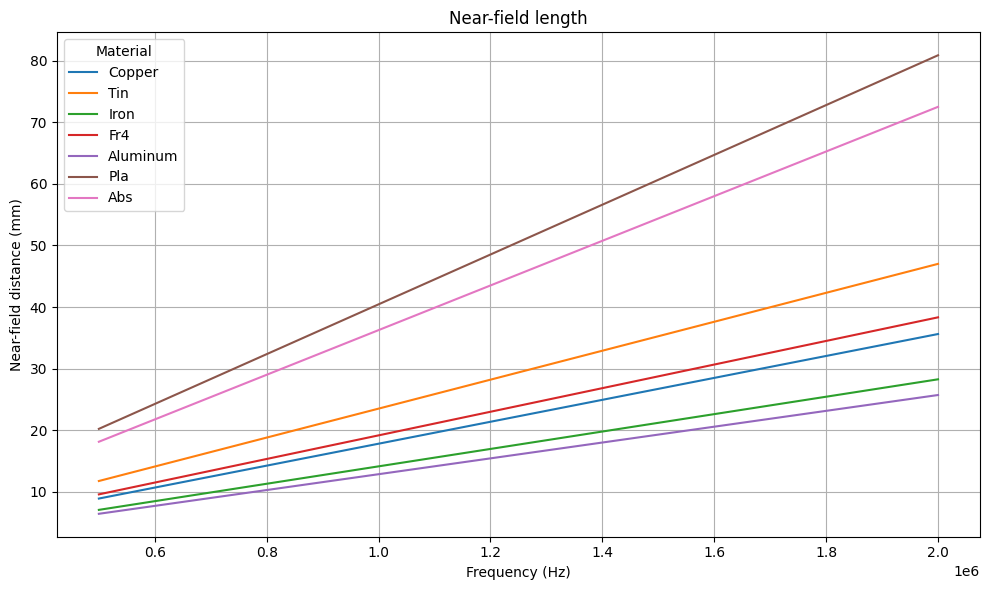

In [ ]:

#! Wave decay
'''
Goal is to measure surface (Raleigh) wave propagation to measure basic properties
- 2 piezo-electrics are often set a few wavelengths apart.
- This makes sure you're in the far-field (beyond the Ryleigh distance)

Pick the measurement distance at about 2-3 times the near-field distance
'''

# Assume transducer diameter of about 1.6 cm (UB161M7)
D_fp = 1.6e-2
D = np.ones_like(frequencies) * D_fp
# Assume ultrasound / piezoelectric frequency between 500 kHz and 2 MHz
f_piezo = frequencies
print(f"piezo-frequencies: {f_piezo.shape}")

# Get the 
plt.figure(figsize=(10, 6))
for idx, (material, speeds) in enumerate(materials_data.items()):
	N = (D**2 / (4*wavelengths_avg_dict[material.capitalize()]))*1e3
	plt.plot(frequencies, N, label=material.capitalize())
    
plt.title('Near-field length')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Near-field distance (mm)')
plt.legend(title='Material')
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusion
- The higher we go in frequency, the more the absolute difference in wavelength decreases.
- The ratio of the wavelengths stays the same.
- Pick a piezo-element of about 25 mm diameter
- Design the transmitter / reciever circuit for frequencies between 500 kHz and 2 MHz


## Piezo-electric transducer availability
Check:
- The source impedance
- The resonance frequency
- The resonance impedance
### Examples
- UB161M7
	- Mouser / Digikey availability (4 euros)
	- Circular shape, positive internal ring, negative external ring (good for shear waves)
	- resonance frequency: 1.7 MHz
- M165D25
	- Farnell (24 euros)
	- More for fluids, waterproof
	- resonance frequency: 1.65 MHz
	- Maybe for testing

For initial testing: go with the UB161M7
You can
- Do characterization using a VNA
- Encapsulate 2 of them in a transparent, electrically insulating layer (epoxy, RTV silicone, Parylene)
- Connect the transmitter to an STM32 PWM
- Connect the receiver to an STM32 ADC
- do a first series of TOF tests inside water.

# ADC choice
- xADC for Spartan 7: 12-bit, 1 MSPS
- STM32 Sampling rate (stm32f303cbt6): 9 MSPS max (fast mode)

# M16D25
f_res = 1.65e3
R_res = 2
c = 2000e12